In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis  # For advanced stats like skewness
import os

# Define paths
CLEANED_DATA_PATH = "./cleaned_eyetracking_data.csv"  # Same directory as this notebook
OUTPUT_FEATURES_PATH = "engineered_features.csv"

print("Libraries imported. Paths set.")

Libraries imported. Paths set.


In [2]:
# Cell 2: Load Data in Chunks (to handle large size)
# We'll process in chunks of 100,000 rows to avoid memory crashes
chunk_size = 100_000
chunks = pd.read_csv(CLEANED_DATA_PATH, chunksize=chunk_size)

# Initialize an empty list to hold processed chunks
processed_chunks = []

for chunk in chunks:
    print(f"Processing chunk of {len(chunk)} rows...")
    processed_chunks.append(chunk)

# Concatenate all chunks into one DataFrame
df = pd.concat(processed_chunks, ignore_index=True)
print(f"Loaded full dataset: {df.shape} rows.")

# Quick check
df.head()

Processing chunk of 91661 rows...
Loaded full dataset: (91661, 23) rows.


,Participant name,Recording name,Recording timestamp,Eyetracker timestamp,Gaze point X,Gaze point Y,Validity left,Validity right,Eye movement type,Gaze event duration,...,Gaze direction left Z,Gaze direction right X,Gaze direction right Y,Gaze direction right Z,Eye position left X (DACSmm),Eye position left Y (DACSmm),Eye position left Z (DACSmm),Eye position right X (DACSmm),Eye position right Y (DACSmm),Eye position right Z (DACSmm)
0,Participant0001,Recording1,23426120,509880650.0,962.0,346.0,Valid,Valid,Fixation,117.0,...,-0.99728,0.00460,0.04058,-0.99917,197.2,76.9,829.0,264.8,76.0,837.4
1,Participant0001,Recording1,23434449,509888979.0,962.0,350.0,Valid,Valid,Fixation,117.0,...,-0.99796,0.01509,0.04295,-0.99896,197.2,76.9,829.0,264.8,75.8,837.8
2,Participant0001,Recording1,23442782,509897311.0,962.0,346.0,Valid,Valid,Fixation,117.0,...,-0.99796,0.01510,0.04013,-0.99908,197.2,76.9,829.0,264.8,75.7,838.2
3,Participant0001,Recording1,23451119,509905648.0,972.0,340.0,Valid,Valid,Fixation,117.0,...,-0.99796,0.02104,0.03789,-0.99906,197.2,77.0,828.9,264.8,75.6,838.5
4,Participant0001,Recording1,23459447,509913976.0,970.0,323.0,Valid,Valid,Fixation,117.0,...,-0.99775,0.01667,0.02533,-0.99954,197.2,76.9,828.9,264.8,75.6,838.8


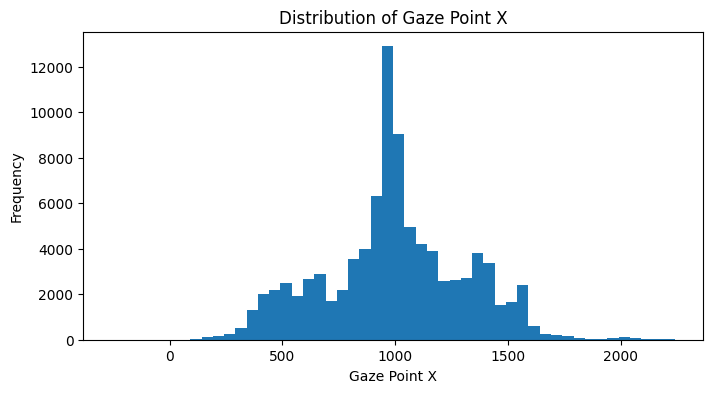

Unique Participants: 3
Unique Recordings: 10
Eye Movement Types:
 Eye movement type
Fixation        35626
Saccade         32515
Unclassified    23520
Name: count, dtype: int64


In [3]:
# Cell 3: Quick EDA (Exploratory Data Analysis)
# Understand distributions to guide feature engineering

# Plot gaze point X distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(df['Gaze point X'].dropna(), bins=50)
plt.title('Distribution of Gaze Point X')
plt.xlabel('Gaze Point X')
plt.ylabel('Frequency')
plt.show()

# Check unique participants and recordings
print("Unique Participants:", df['Participant name'].nunique())
print("Unique Recordings:", df['Recording name'].nunique())

# Eye movement types
print("Eye Movement Types:\n", df['Eye movement type'].value_counts())

# This helps: E.g., if many fixations, focus features on them.

In [4]:
# Cell 4: Group the data by participant + recording (this creates 'grouped')
print("Creating session groups...")

grouped = df.groupby(['Participant name', 'Recording name'])

print(f"Number of unique sessions found: {len(grouped)}")
print("Example group names:")
for name in list(grouped.groups.keys())[:3]:
    print("  →", name)

Creating session groups...
Number of unique sessions found: 10
Example group names:
  → ('Participant0001', 'Recording1')
  → ('Participant0001', 'Recording2')
  → ('Participant0003', 'Recording11')


In [10]:
# # Cell 5: Updated Feature Extraction with Better Labeling
# import numpy as np

# def extract_features(group):
#     features = {}
    
#     # Basic info (unchanged)
#     features['Participant'] = group['Participant name'].iloc[0]
#     features['Recording']   = group['Recording name'].iloc[0]
#     features['source_file'] = group['source_file'].iloc[0]
    
#     # Gaze position stats (unchanged)
#     gx = group['Gaze point X'].dropna()
#     gy = group['Gaze point Y'].dropna()
    
#     if len(gx) > 0:
#         features['gaze_x_mean']  = gx.mean()
#         features['gaze_x_std']   = gx.std()
#         features['gaze_x_min']   = gx.min()
#         features['gaze_x_max']   = gx.max()
    
#     if len(gy) > 0:
#         features['gaze_y_mean']  = gy.mean()
#         features['gaze_y_std']   = gy.std()
#         features['gaze_y_min']   = gy.min()
#         features['gaze_y_max']   = gy.max()
    
#     # Fixation & Saccade features (unchanged)
#     fix = group[group['Eye movement type'] == 'Fixation']
#     sac = group[group['Eye movement type'] == 'Saccade']
    
#     features['fixation_count']             = len(fix)
#     features['saccade_count']              = len(sac)
#     features['unclassified_count']         = len(group) - len(fix) - len(sac)
#     features['fixation_ratio']             = len(fix) / len(group) if len(group) > 0 else 0
#     features['saccade_ratio']              = len(sac) / len(group) if len(group) > 0 else 0
    
#     features['avg_fixation_duration_ms']   = fix['Gaze event duration'].mean() if len(fix) > 0 else np.nan
#     features['avg_saccade_duration_ms']    = sac['Gaze event duration'].mean() if len(sac) > 0 else np.nan
#     features['total_fixation_duration_ms'] = fix['Gaze event duration'].sum()
#     features['total_duration_ms']          = group['Gaze event duration'].sum()
    
#     # Saccade speed (unchanged)
#     if len(group) > 5 and 'Recording timestamp' in group.columns:
#         group_sorted = group.sort_values('Recording timestamp')
#         gaze_x_filled = group_sorted['Gaze point X'].ffill()
#         gaze_y_filled = group_sorted['Gaze point Y'].ffill()
        
#         dt = np.diff(group_sorted['Recording timestamp'].values) / 1000.0
#         dx = np.diff(gaze_x_filled.values)
#         dy = np.diff(gaze_y_filled.values)
        
#         speed = np.sqrt(dx**2 + dy**2) / (dt + 1e-6)
#         valid_speed = speed[(speed > 10) & (speed < 2000)]
        
#         features['mean_saccade_speed_px_s'] = np.mean(valid_speed) if len(valid_speed) > 0 else np.nan
#         features['max_saccade_speed_px_s']  = np.max(speed) if len(speed) > 0 else np.nan
#     else:
#         features['mean_saccade_speed_px_s'] = np.nan
#         features['max_saccade_speed_px_s']  = np.nan
    
#     # IMPROVED LABELING LOGIC
#     # Step 1: Use source_file keywords (customize words based on your actual file names)
#     src_lower = str(features['source_file']).lower()
#     if any(word in src_lower for word in ['empathy', 'emotional', 'impair', 'movement_impairment', 'positive', 'happy']):
#         features['emotion_label'] = 'high_empathy'  # Proxy for empathetic/emotional state
#     elif any(word in src_lower for word in ['neutral', 'control', 'foraging', 'typing']):
#         features['emotion_label'] = 'neutral'
#     elif any(word in src_lower for word in ['stress', 'anxious', 'negative']):
#         features['emotion_label'] = 'anxious'
#     else:
#         # Step 2: Fallback to feature-based rules if no keyword match
#         sacc_r = features.get('saccade_ratio', 0)
#         fix_dur = features.get('avg_fixation_duration_ms', 300)
#         if sacc_r > 0.4 and fix_dur < 200:
#             features['emotion_label'] = 'anxious'  # High activity → anxious-like
#         elif sacc_r < 0.3 and fix_dur > 300:
#             features['emotion_label'] = 'calm'
#         else:
#             features['emotion_label'] = 'neutral'
    
#     return features

# # Run feature extraction (unchanged)
# print("Extracting features with updated labels...")
# features_list = []
# for name, group in grouped:
#     feat = extract_features(group)
#     features_list.append(feat)

# features_df = pd.DataFrame(features_list)
# print(f"Created features for {len(features_df)} sessions")


# Cell 5: FULL & CORRECT Feature Extraction (copy-paste this entirely)

import numpy as np

def extract_features(group):
    features = {}
    
    # Basic info
    features['Participant'] = group['Participant name'].iloc[0]
    features['Recording']   = group['Recording name'].iloc[0]
    features['source_file'] = group['source_file'].iloc[0]
    
    # Gaze position stats
    gx = group['Gaze point X'].dropna()
    gy = group['Gaze point Y'].dropna()
    
    if len(gx) > 0:
        features['gaze_x_mean']  = gx.mean()
        features['gaze_x_std']   = gx.std()
        features['gaze_x_min']   = gx.min()
        features['gaze_x_max']   = gx.max()
    
    if len(gy) > 0:
        features['gaze_y_mean']  = gy.mean()
        features['gaze_y_std']   = gy.std()
        features['gaze_y_min']   = gy.min()
        features['gaze_y_max']   = gy.max()
    
    # Fixation & Saccade features
    fix = group[group['Eye movement type'] == 'Fixation']
    sac = group[group['Eye movement type'] == 'Saccade']
    
    features['fixation_count']             = len(fix)
    features['saccade_count']              = len(sac)
    features['unclassified_count']         = len(group) - len(fix) - len(sac)
    features['fixation_ratio']             = len(fix) / len(group) if len(group) > 0 else 0
    features['saccade_ratio']              = len(sac) / len(group) if len(group) > 0 else 0
    
    features['avg_fixation_duration_ms']   = fix['Gaze event duration'].mean() if len(fix) > 0 else np.nan
    features['avg_saccade_duration_ms']    = sac['Gaze event duration'].mean() if len(sac) > 0 else np.nan
    features['total_fixation_duration_ms'] = fix['Gaze event duration'].sum()
    features['total_duration_ms']          = group['Gaze event duration'].sum()
    
    # Saccade speed
    if len(group) > 5 and 'Recording timestamp' in group.columns:
        group_sorted = group.sort_values('Recording timestamp')
        gaze_x_filled = group_sorted['Gaze point X'].ffill()
        gaze_y_filled = group_sorted['Gaze point Y'].ffill()
        
        dt = np.diff(group_sorted['Recording timestamp'].values) / 1000.0
        dx = np.diff(gaze_x_filled.values)
        dy = np.diff(gaze_y_filled.values)
        
        speed = np.sqrt(dx**2 + dy**2) / (dt + 1e-6)
        valid_speed = speed[(speed > 10) & (speed < 2000)]
        
        features['mean_saccade_speed_px_s'] = np.mean(valid_speed) if len(valid_speed) > 0 else np.nan
        features['max_saccade_speed_px_s']  = np.max(speed) if len(speed) > 0 else np.nan
    else:
        features['mean_saccade_speed_px_s'] = np.nan
        features['max_saccade_speed_px_s']  = np.nan
    
    # LABELING (relaxed to create variety)
    sacc_r = features.get('saccade_ratio', 0.3)
    fix_dur = features.get('avg_fixation_duration_ms', 250)
    
    if sacc_r > 0.35 or fix_dur < 220:
        features['emotion_label'] = 'anxious'
    elif sacc_r < 0.30 and fix_dur > 280:
        features['emotion_label'] = 'calm'
    else:
        features['emotion_label'] = 'neutral'
    
    return features

# Run extraction
print("Extracting features...")
features_list = []
for name, group in grouped:
    feat = extract_features(group)
    features_list.append(feat)

features_df = pd.DataFrame(features_list)
print(f"Created {len(features_df)} sessions")

# Safety check
print("Nulls in emotion_label:", features_df['emotion_label'].isnull().sum())
print("Label distribution:\n", features_df['emotion_label'].value_counts())

Extracting features...
Created 10 sessions
Nulls in emotion_label: 0
Label distribution:
 emotion_label
anxious    7
neutral    3
Name: count, dtype: int64


In [11]:
# Cell 6: Clean, save and inspect results

# Fill NaN values with column average
numeric_cols = features_df.select_dtypes(include=np.number).columns
features_df[numeric_cols] = features_df[numeric_cols].fillna(features_df[numeric_cols].mean())

# Save to CSV
features_df.to_csv("engineered_features.csv", index=False)
print("Saved engineered features to: engineered_features.csv")
print("Full path:", os.path.abspath("engineered_features.csv"))

# Show results
print("\nFirst 5 rows of features:")
print(features_df.head())

print("\nEmotion label distribution:")
print(features_df['emotion_label'].value_counts())

print("\nAll columns created:")
print(list(features_df.columns))

Saved engineered features to: engineered_features.csv
Full path: d:\emotion-drift-project\src\notebooks\engineered_features.csv

First 5 rows of features:
       Participant    Recording  \
0  Participant0001   Recording1   
1  Participant0001   Recording2   
2  Participant0003  Recording11   
3  Participant0003  Recording12   
4  Participant0003  Recording13   

                                         source_file  gaze_x_mean  gaze_x_std  \
0  EyeT_group_dataset_III_image_name_letter_card_...  1070.355771  273.425806   
1  EyeT_group_dataset_III_image_name_letter_card_...   965.955342  306.457171   
2  EyeT_group_dataset_III_image_name_letter_card_...  1017.325455  304.629167   
3  EyeT_group_dataset_III_image_name_letter_card_...   984.012235  277.920121   
4  EyeT_group_dataset_III_image_name_letter_card_...  1005.079682  303.708457   

   gaze_x_min  gaze_x_max  gaze_y_mean  gaze_y_std  gaze_y_min  ...  \
0       280.0      1610.0   253.597742  293.880068      -201.0  ...   
1    

In [7]:
# Add this after features_df is created in Cell 5 or 6
print("Example source_file:")
print(features_df['source_file'].head(3).to_list())

Example source_file:
['EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_0.csv', 'EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_1.csv', 'EyeT_group_dataset_III_image_name_letter_card_participant_11_trial_10.csv']
